### This notebook looks at the impact of systematically deleting SC ...the INNER connectivity i.e., from ntwx A to itself, ntwx B to itself when ntwx X is isolated ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [242]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [243]:
from collections import Counter

In [347]:
import seaborn as sns
import scipy.stats as stats

In [244]:
import pickle

In [418]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [246]:
import re

In [247]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [248]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [249]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [250]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 5s, sys: 681 ms, total: 1min 6s
Wall time: 1min 40s


In [251]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.42 s, sys: 76.5 ms, total: 1.49 s
Wall time: 1.49 s


In [252]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [253]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [254]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 3min 7s, sys: 6.6 s, total: 3min 14s
Wall time: 7min 51s


In [20]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is INNER connectivity ... i.e., the average ntwx conn to itself (so Vis to Vis, DMN to DMN, etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

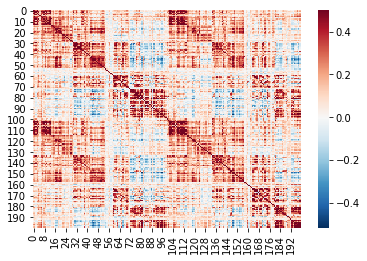

In [42]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

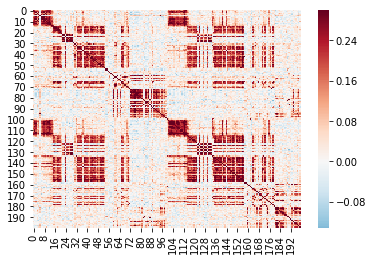

In [29]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [50]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [68]:
# corrs_list

[0.6200089167105477,
 0.6102467277725079,
 0.6647353853416271,
 0.6105464220191049,
 0.5379972089268263,
 0.675883045094604,
 0.6239469367464171,
 0.6132007413933916,
 0.5837859181933756,
 0.6492939860396871,
 0.7374194244219163,
 0.6710034619810292,
 0.5394807075259581,
 0.5806288462428778,
 0.5982522049650677,
 0.6366729218134846,
 0.6030707053415126,
 0.6572905193196694,
 0.6010094762339514,
 0.6488142220173515,
 0.5245148072609505,
 0.6565371180433753,
 0.5781901714645522,
 0.6217488344580433,
 0.5966773773493769,
 0.6554716971703077,
 0.5576062751599197,
 0.5865148566711488,
 0.5542586436140655,
 0.6609837658617055,
 0.6338557861231642,
 0.548438190044074,
 0.5830333296724894,
 0.6248622556172462,
 0.5231213312296725,
 0.6002683514745389,
 0.6045090645767037,
 0.5331416099239052,
 0.6089704590386142,
 0.584712181942719,
 0.5732585860625157,
 0.7285941975321231,
 0.6512142453917102,
 0.5238308575442,
 0.6058819571026307,
 0.5924403190323927,
 0.5892441829996325,
 0.5669979812301901

In [149]:
# ntwx_only_lh[(ntwx_only_lh>0.1)] # & (ntwx_only_rh<0.9)

In [184]:
fc = all_subs_og_whobpyt
sub = 147
a = 54
b = 60
c = 158
d = 164


In [185]:
ntwx_only_lh = fc[sub][a:b, a:b]
ntwx_only_rh = fc[sub][c:d, c:d]

ntwx_only_lhrh = fc[sub][a:b, c:d]
ntwx_only_rhlh = fc[sub][c:d, a:b]

In [186]:
ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>0.1)]


In [187]:
ntwx_only_lh

array([1.        , 0.85091794, 0.19923905, 0.85091794, 1.        ,
       0.19096105, 1.        , 0.80467299, 0.73434531, 0.80467299,
       1.        , 0.53763105, 0.73434531, 0.53763105, 1.        ,
       0.19923905, 0.19096105, 1.        ])

In [188]:
def ntwx_only_fc_with_thresh(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>0.1)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh>0.1)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh>0.1)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh>0.1)]
    
    # Replace NaN values with 0 in ntwx_only_lh
    ntwx_only_lh[np.isnan(ntwx_only_lh)] = 0

    # Replace NaN values with 0 in ntwx_only_rh
    ntwx_only_rh[np.isnan(ntwx_only_rh)] = 0

    # Replace NaN values with 0 in ntwx_only_lhrh
    ntwx_only_lhrh[np.isnan(ntwx_only_lhrh)] = 0

    # Replace NaN values with 0 in ntwx_only_rhlh
    ntwx_only_rhlh[np.isnan(ntwx_only_rhlh)] = 0
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [71]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [ ]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [113]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### original whobpyt

In [162]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs)
org_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs)
org_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs)
org_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(org_whobpyt_limbic_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 145 ms, sys: 18.5 ms, total: 163 ms
Wall time: 149 ms


In [163]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

In [256]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [263]:
org2_whobpyt_means, org2_all_subs = func_for_inner_ntwx_connectivity(all_subs_og_whobpyt)

In [348]:
org_whobpyt_df = pd.DataFrame(org2_all_subs,index=ntwx_labels)

org_whobpyt_df = org_whobpyt_df.T

# org_whobpyt_df

In [349]:
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means, sommot_all_subs = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means, dorsattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means, ventattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means, limbic_all_subs = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

In [485]:
ntwx_lesion_whobpyt_means = [vis_lesion_whobpyt_means,
sommot_lesion_whobpyt_means,
dorsattn_lesion_whobpyt_means,
ventattn_lesion_whobpyt_means,
limbic_lesion_whobpyt_means,
fpn_lesion_whobpyt_means,
dmn_lesion_whobpyt_means]

In [488]:
org2_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

In [487]:
for i in range(7):
    print(ntwx_lesion_whobpyt_means[i][i])

0.22095023227519278
0.12677625732806674
0.1271467191709178
0.11942177364233836
0.10989118050524901
0.11352077571836076
0.12044374319327826


In [350]:
vis_lesion_df = pd.DataFrame(vis_all_subs,index=ntwx_labels)
vis_lesion_df = vis_lesion_df.T

sommot_lesion_df = pd.DataFrame(sommot_all_subs,index=ntwx_labels)
sommot_lesion_df = sommot_lesion_df.T

dorsattn_lesion_df = pd.DataFrame(dorsattn_all_subs,index=ntwx_labels)
dorsattn_lesion_df = dorsattn_lesion_df.T

ventattn_lesion_df = pd.DataFrame(ventattn_all_subs,index=ntwx_labels)
ventattn_lesion_df = ventattn_lesion_df.T


limbic_lesion_df = pd.DataFrame(limbic_all_subs,index=ntwx_labels)
limbic_lesion_df = limbic_lesion_df.T

fpn_lesion_df = pd.DataFrame(fpn_all_subs,index=ntwx_labels)
fpn_lesion_df = fpn_lesion_df.T

dmn_lesion_df = pd.DataFrame(dmn_all_subs,index=ntwx_labels)
dmn_lesion_df = dmn_lesion_df.T

In [345]:
# plt.hist(org2_all_subs[5],bins=20)
# plt.show()

In [346]:
# plt.hist(vis_all_subs[5],bins=20)
# plt.show()

In [285]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

#### Visual lesion stats

In [351]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], vis_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 2.1918122785084524
P-Value: 0.028971780128089243 

-------------------
Network =  SomMot
T-Statistic: 2.566781049975764
P-Value: 0.010629466627696843 

-------------------
Network =  DorsAttn
T-Statistic: 6.055403299227368
P-Value: 3.2430654724720503e-09 

-------------------
Network =  VentAttn
T-Statistic: 4.278264989044676
P-Value: 2.3617713697452673e-05 

-------------------
Network =  Limbic
T-Statistic: -0.8529745637141142
P-Value: 0.39418643292110755 

-------------------
Network =  FPN
T-Statistic: -0.535757092525937
P-Value: 0.5924257020126305 

-------------------
Network =  DMN
T-Statistic: -0.1773776133088518
P-Value: 0.8593020259761668 

-------------------


#### SomMot lesion stats

In [352]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], sommot_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.7229716433103364
P-Value: 0.47012194180476374 

-------------------
Network =  SomMot
T-Statistic: 7.65027901299117
P-Value: 1.5262827079963568e-13 

-------------------
Network =  DorsAttn
T-Statistic: 1.3944144232302647
P-Value: 0.16397035304296564 

-------------------
Network =  VentAttn
T-Statistic: 1.1373363238655
P-Value: 0.25608196164981883 

-------------------
Network =  Limbic
T-Statistic: -0.3231801419023095
P-Value: 0.7467285486733655 

-------------------
Network =  FPN
T-Statistic: -0.28434513052865207
P-Value: 0.7762937827310523 

-------------------
Network =  DMN
T-Statistic: -0.18115226615565325
P-Value: 0.8563402749152744 

-------------------


#### DorsAttn lesion stats

In [353]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], dorsattn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 3.3063972303233093
P-Value: 0.0010308589459768194 

-------------------
Network =  SomMot
T-Statistic: 2.673159108564464
P-Value: 0.007823184469519323 

-------------------
Network =  DorsAttn
T-Statistic: 10.653460552290015
P-Value: 1.7458873800830524e-23 

-------------------
Network =  VentAttn
T-Statistic: 3.859081075089026
P-Value: 0.00013274950379507384 

-------------------
Network =  Limbic
T-Statistic: -0.7244080136109908
P-Value: 0.4692408990149646 

-------------------
Network =  FPN
T-Statistic: 0.5307792696688235
P-Value: 0.5958677910191998 

-------------------
Network =  DMN
T-Statistic: -0.49092153899668994
P-Value: 0.6237525132555342 

-------------------


#### VentAttn lesion stats

In [354]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], ventattn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.20906187791009467
P-Value: 0.83450689335589 

-------------------
Network =  SomMot
T-Statistic: 1.3807033788871128
P-Value: 0.16814503269258954 

-------------------
Network =  DorsAttn
T-Statistic: 2.817481680200886
P-Value: 0.00508144250972376 

-------------------
Network =  VentAttn
T-Statistic: 10.260643725298422
P-Value: 4.507249445243294e-22 

-------------------
Network =  Limbic
T-Statistic: -0.6755519196036781
P-Value: 0.49971748387708403 

-------------------
Network =  FPN
T-Statistic: 0.25560990972347625
P-Value: 0.7983841132064041 

-------------------
Network =  DMN
T-Statistic: -0.4985659124133953
P-Value: 0.6183606388566429 

-------------------


#### Limbic lesion stats

In [355]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], limbic_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.08805267398039192
P-Value: 0.92987909752812 

-------------------
Network =  SomMot
T-Statistic: -0.3218156676927419
P-Value: 0.7477612967650145 

-------------------
Network =  DorsAttn
T-Statistic: -0.02069987955951117
P-Value: 0.9834954384931955 

-------------------
Network =  VentAttn
T-Statistic: -0.015395051030470324
P-Value: 0.9877247258978461 

-------------------
Network =  Limbic
T-Statistic: 3.4189053507611376
P-Value: 0.0006936717650797313 

-------------------
Network =  FPN
T-Statistic: -0.1689991957800183
P-Value: 0.8658831298620449 

-------------------
Network =  DMN
T-Statistic: -0.42139170559083833
P-Value: 0.6736965598266739 

-------------------


####  FPN lesion stats

In [356]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], fpn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -1.1227251585245779
P-Value: 0.26223105527986834 

-------------------
Network =  SomMot
T-Statistic: -0.5010761258175471
P-Value: 0.6165945578078953 

-------------------
Network =  DorsAttn
T-Statistic: -0.2442247144554071
P-Value: 0.8071826368904121 

-------------------
Network =  VentAttn
T-Statistic: -0.06190530130126077
P-Value: 0.9506693211623957 

-------------------
Network =  Limbic
T-Statistic: -0.3930003229230903
P-Value: 0.6945296553192257 

-------------------
Network =  FPN
T-Statistic: 3.533910331711124
P-Value: 0.00045754537857580976 

-------------------
Network =  DMN
T-Statistic: 1.1852195687367746
P-Value: 0.2366378324658705 

-------------------


#### DMN lesion stats

In [357]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_ind(org2_all_subs[i], dmn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -1.2810845156747546
P-Value: 0.20090992531161384 

-------------------
Network =  SomMot
T-Statistic: -0.7404683636696552
P-Value: 0.4594524469881842 

-------------------
Network =  DorsAttn
T-Statistic: -0.6419175027440281
P-Value: 0.5212962851631116 

-------------------
Network =  VentAttn
T-Statistic: -0.6846377698184283
P-Value: 0.49397101248154496 

-------------------
Network =  Limbic
T-Statistic: 1.7628559796132663
P-Value: 0.07869219681459638 

-------------------
Network =  FPN
T-Statistic: 0.8412361789472491
P-Value: 0.40072077558974517 

-------------------
Network =  DMN
T-Statistic: 1.9788981481816226
P-Value: 0.048516347221028815 

-------------------


In [331]:
org_whobpyt_df['source'] = 'original WhoBPyT'
vis_lesion_df['source'] = 'Visual Ntwx Lesion'

In [332]:
# Concatenate the two DataFrames
combined_df = pd.concat([org_whobpyt_df, vis_lesion_df], ignore_index=True)

In [333]:
combined_df

,Vis,SomMot,DorsAttn,VentAttn,Limbic,FPN,DMN,source
0,0.191001,0.303639,0.322567,0.236269,0.109752,0.100019,0.104810,original WhoBPyT
1,0.264096,0.125702,0.162918,0.183321,0.116788,0.129781,0.208291,original WhoBPyT
2,0.261152,0.250092,0.249454,0.227149,0.093237,0.091693,0.087747,original WhoBPyT
3,0.289538,0.133205,0.241618,0.210131,0.125961,0.131538,0.124288,original WhoBPyT
4,0.241123,0.133470,0.191564,0.263229,0.115939,0.104128,0.118492,original WhoBPyT
...,...,...,...,...,...,...,...,...
395,0.066823,0.151720,0.274359,0.204641,0.137307,0.170939,0.111988,Visual Ntwx Lesion
396,0.255380,0.086979,0.086360,0.094757,0.107067,0.142084,0.105483,Visual Ntwx Lesion
397,0.280054,0.202597,0.136827,0.160042,0.089907,0.163119,0.159212,Visual Ntwx Lesion
398,0.249323,0.299685,0.227242,0.220882,0.152472,0.125200,0.139880,Visual Ntwx Lesion


In [334]:
combined_df_long = combined_df.melt(id_vars=['source'],value_vars=ntwx_labels)

In [335]:
combined_df_long

,source,variable,value
0,original WhoBPyT,Vis,0.191001
1,original WhoBPyT,Vis,0.264096
2,original WhoBPyT,Vis,0.261152
3,original WhoBPyT,Vis,0.289538
4,original WhoBPyT,Vis,0.241123
...,...,...,...
2795,Visual Ntwx Lesion,DMN,0.111988
2796,Visual Ntwx Lesion,DMN,0.105483
2797,Visual Ntwx Lesion,DMN,0.159212
2798,Visual Ntwx Lesion,DMN,0.139880


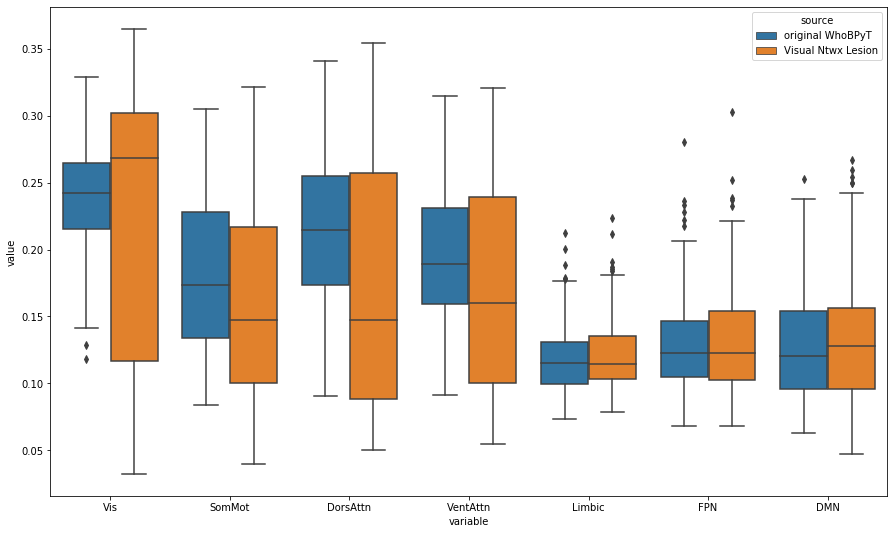

In [344]:
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.boxplot(data=combined_df_long,x='variable',y='value',hue='source')


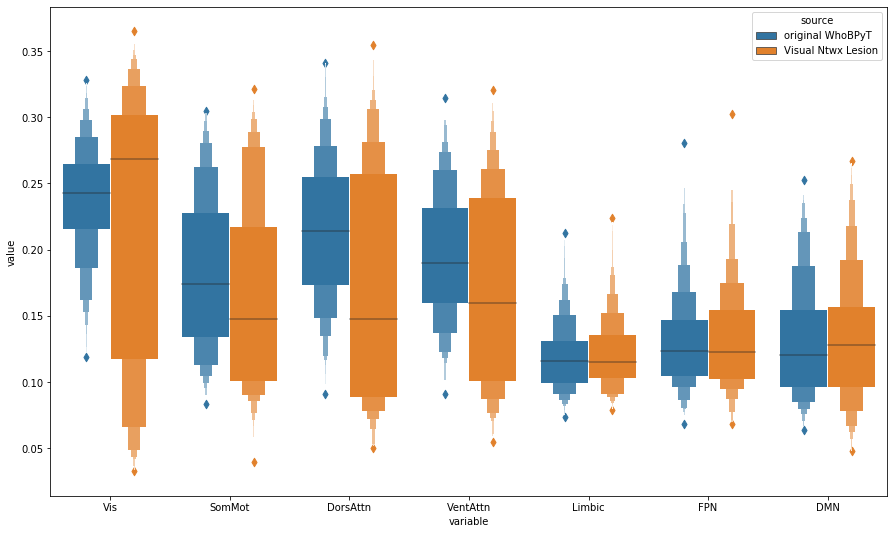

In [339]:
fig, ax = plt.subplots(figsize=(15,9))
sns.boxenplot(data=combined_df_long,x='variable',y='value',hue='source')

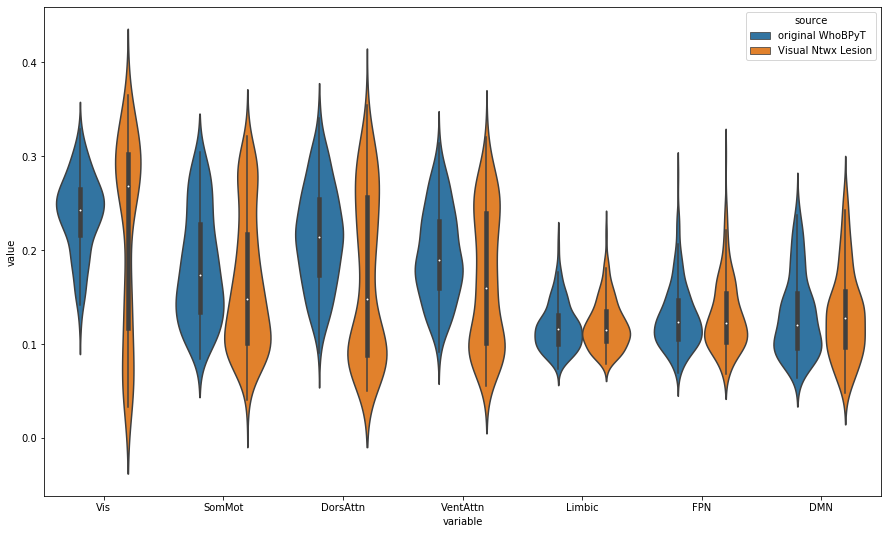

In [340]:
fig, ax = plt.subplots(figsize=(15,9))
sns.violinplot(data=combined_df_long,x='variable',y='value',hue='source')

In [321]:
# sns.violinplot(data=combined_df,hue='source')

# plt.show()


####  Visual

In [477]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

In [483]:
print('VIS')
print(org_whobpyt_means)
print(vis_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('SMT')
print(org_whobpyt_means)
print(sommot_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('DAN')
print(org_whobpyt_means)
print(dorsattn_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('VAN')
print(org_whobpyt_means)
print(ventattn_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('LIM')
print(org_whobpyt_means)
print(limbic_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('FPN')
print(org_whobpyt_means)
print(fpn_lesion_whobpyt_means)
print('\n')
print('-----')
print('\n')
print('DMN')
print(org_whobpyt_means)
print(dmn_lesion_whobpyt_means)

VIS
[0.2381039300052709, 0.18159082694176334, 0.21459717983754742, 0.19481845006681628, 0.11863332314529478, 0.12874539763860968, 0.1304547462593384]
[0.22095023227519278, 0.16480635231212337, 0.17092401286761852, 0.1685375150117475, 0.12085003032176893, 0.1306977686117268, 0.13126494980300263]


-----


SMT
[0.2381039300052709, 0.18159082694176334, 0.21459717983754742, 0.19481845006681628, 0.11863332314529478, 0.12874539763860968, 0.1304547462593384]
[0.24153095633537588, 0.12677625732806674, 0.20615477398627355, 0.18839611472070636, 0.11944785930644272, 0.1297336838620799, 0.13125127614980614]


-----


DAN
[0.2381039300052709, 0.18159082694176334, 0.21459717983754742, 0.19481845006681628, 0.11863332314529478, 0.12874539763860968, 0.1304547462593384]
[0.21725011764502988, 0.16423627079951508, 0.1271467191709178, 0.17208978537802896, 0.12051713746286091, 0.1267853165682671, 0.13268135947294393]


-----


VAN
[0.2381039300052709, 0.18159082694176334, 0.21459717983754742, 0.194818450066

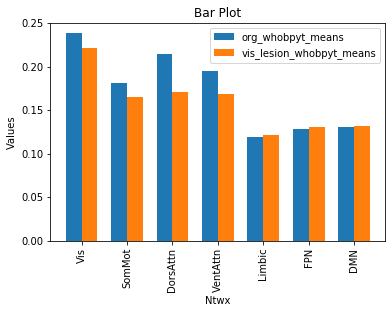

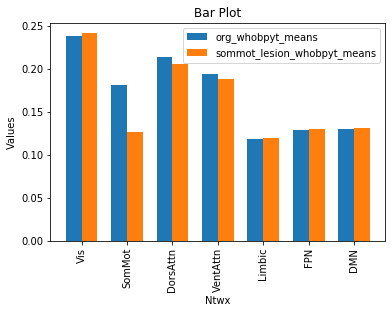

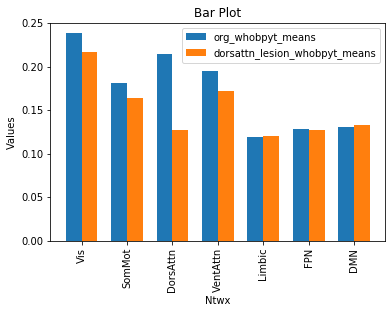

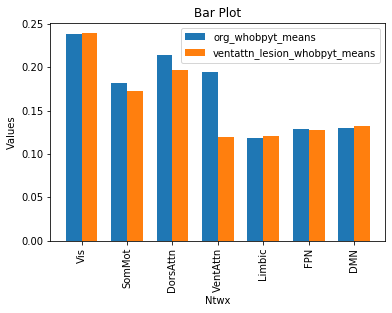

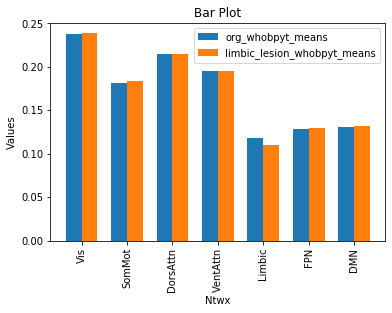

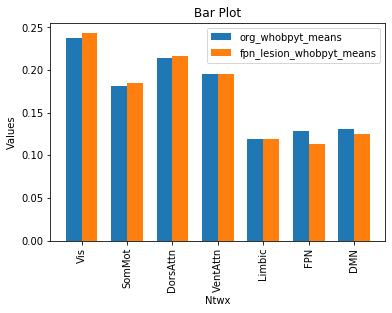

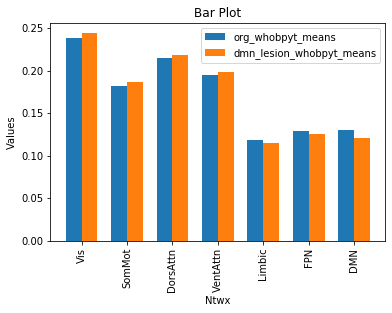

In [406]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means, width, label='vis_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means, width, label='sommot_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means, width, label='dorsattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means, width, label='ventattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means, width, label='limbic_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means, width, label='fpn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means, width, label='dmn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

## -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

### With threshold (>0.1, etc)

In [469]:
def ntwx_only_fc_with_thresh(fc, sub, a,b,c,d):
    
    thresh = 0.1
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>thresh)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh>thresh)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh>thresh)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh>thresh)]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [470]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs_thresh = []
org_whobpyt_sommot_mean_fc_all_subs_thresh = []
org_whobpyt_dorsattn_mean_fc_all_subs_thresh = []
org_whobpyt_ventattn_mean_fc_all_subs_thresh = []
org_whobpyt_limbic_mean_fc_all_subs_thresh = []
org_whobpyt_fpn_mean_fc_all_subs_thresh = []
org_whobpyt_dmn_mean_fc_all_subs_thresh = []

for i in range(200):
    
    temp_vis = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs_thresh.append(temp_vis)
    
    temp_sommot = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs_thresh.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs_thresh.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs_thresh.append(temp_ventattn)

    temp_limbic = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs_thresh.append(temp_limbic)

    temp_fpn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs_thresh.append(temp_fpn)

    temp_dmn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs_thresh.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_vis_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_sommot_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_dorsattn_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_ventattn_mean_fc_all_subs_thresh, nan=0))
# issue affected limbic ntwx only ...
# hence the custom fix ...
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_limbic_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_fpn_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_dmn_mean_fc_all_subs_thresh, nan=0))


org_whobpyt_means_with_thresh = [org_whobpyt_vis_mean_fc_all_subs_thresh_mean,
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean,
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean,
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean]

CPU times: user 200 ms, sys: 22.6 ms, total: 223 ms
Wall time: 220 ms


In [471]:
org_whobpyt_means_with_thresh

[0.29498809987194613,
 0.26833745171358486,
 0.2821143782660609,
 0.2856733161553926,
 0.29346259121295715,
 0.29425054592299105,
 0.2688045553313299]

In [472]:
# org_whobpyt_means_with_thresh

#### with thresh

In [473]:
def func_for_inner_ntwx_connectivity_with_thresh(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_vis_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs, nan=0))


    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means

In [474]:
#     ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]

In [475]:
%%time
vis_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_vis_lesion)
sommot_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dmn_lesion)

CPU times: user 1.22 s, sys: 90.6 ms, total: 1.31 s
Wall time: 1.31 s


### With threshold (>0.1) figures

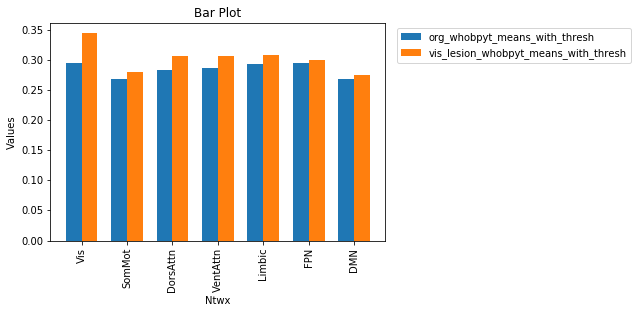

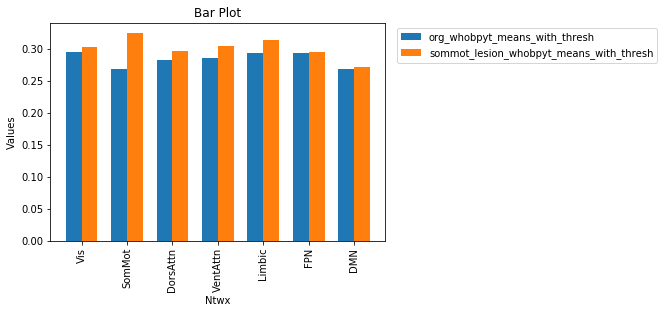

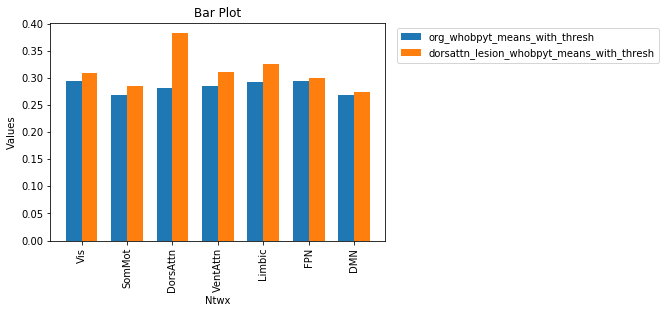

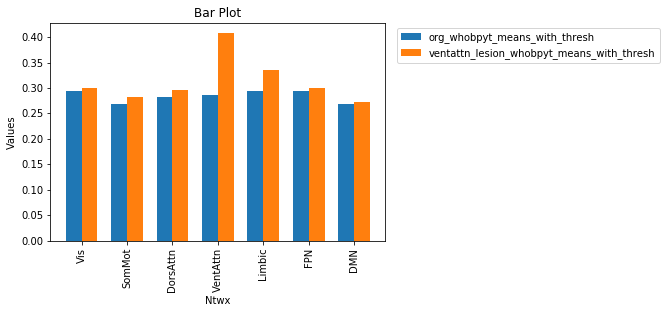

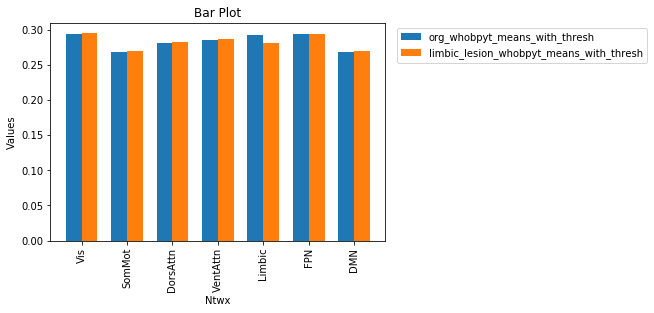

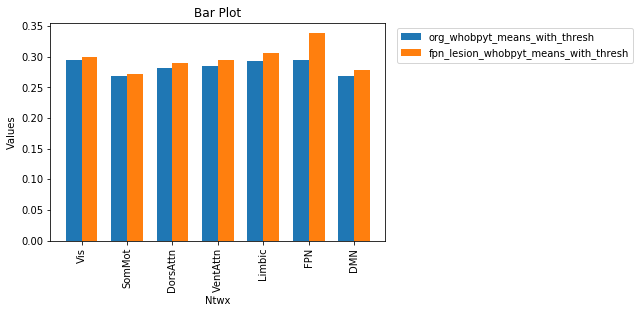

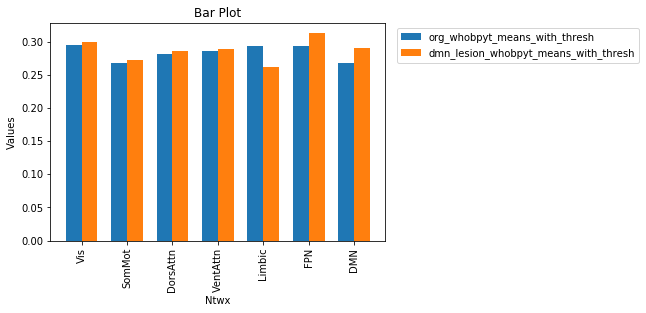

In [476]:
# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means_with_thresh, width, label='vis_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means_with_thresh, width, label='sommot_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means_with_thresh, width, label='dorsattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Ventattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means_with_thresh, width, label='ventattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Limbic

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means_with_thresh, width, label='limbic_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()



#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means_with_thresh, width, label='fpn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means_with_thresh, width, label='dmn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

# -------------------------------------------------------------------------------

### Negative Correlations only (with thresh)

In [455]:
def ntwx_only_fc_with_thresh_negative(fc, sub, a,b,c,d):
    
    thresh = -0.05
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh<thresh)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh<thresh)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh<thresh)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh<thresh)]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [456]:
%%time

# original whobpyt

neg_org_whobpyt_vis_mean_fc_all_subs_thresh = []
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh = []
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh = []
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh = []

for i in range(200):
    
    temp_vis = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    neg_org_whobpyt_vis_mean_fc_all_subs_thresh.append(temp_vis)
    
    temp_sommot = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    neg_org_whobpyt_sommot_mean_fc_all_subs_thresh.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh.append(temp_ventattn)

    temp_limbic = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    neg_org_whobpyt_limbic_mean_fc_all_subs_thresh.append(temp_limbic)

    temp_fpn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    neg_org_whobpyt_fpn_mean_fc_all_subs_thresh.append(temp_fpn)

    temp_dmn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    neg_org_whobpyt_dmn_mean_fc_all_subs_thresh.append(temp_dmn)

    
    
    
neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_vis_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_sommot_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_limbic_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_fpn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_dmn_mean_fc_all_subs_thresh, nan=0))


neg_org_whobpyt_means_with_thresh = [neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh_mean]

CPU times: user 185 ms, sys: 4.73 ms, total: 190 ms
Wall time: 183 ms


In [457]:
neg_org_whobpyt_means_with_thresh

[-0.018225187114513854,
 -0.028053377609951982,
 -0.014800974478388289,
 -0.012218355090750851,
 -0.024353034759264938,
 -0.04927487884362998,
 -0.058542409822648585]

In [458]:
neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean

-0.018225187114513854

In [459]:
print(np.nanmin(neg_org_whobpyt_vis_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_sommot_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_limbic_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_fpn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_dmn_mean_fc_all_subs_thresh))

-0.0815091500266045
-0.07644679833790745
-0.09626256406741499
-0.08258471645447443
-0.09061286980928751
-0.08630018764501401
-0.07465258988629252


In [460]:
def func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_neg_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        neg_ntwx_lesion_temp_vis = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 0, 14, 100, 115)
        neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(neg_ntwx_lesion_temp_vis)

        neg_ntwx_lesion_temp_sommot = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 14, 30, 115, 134)
        neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(neg_ntwx_lesion_temp_sommot)

        neg_ntwx_lesion_temp_dorsattn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 30, 43, 134, 147)
        neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_dorsattn)

        neg_ntwx_lesion_temp_ventattn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 43, 54, 147, 158)
        neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_ventattn)

        neg_ntwx_lesion_temp_limbic = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 54, 60, 158, 164)
        neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(neg_ntwx_lesion_temp_limbic)

        neg_ntwx_lesion_temp_fpn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 60, 73, 164, 181)
        neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_fpn)

        neg_ntwx_lesion_temp_dmn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 73, 100, 181, 200)
        neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_dmn)


    neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs, nan=0))


    neg_ntwx_lesion_whobpyt_means = [neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return neg_ntwx_lesion_whobpyt_means

In [495]:
%%time
neg_vis_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_vis_lesion)
neg_sommot_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_sommot_lesion)
neg_dorsattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_dorsattn_lesion)
neg_ventattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_ventattn_lesion)
neg_limbic_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_limbic_lesion)
neg_fpn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_fpn_lesion)
neg_dmn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_dmn_lesion)

CPU times: user 1.18 s, sys: 229 ms, total: 1.41 s
Wall time: 1.41 s


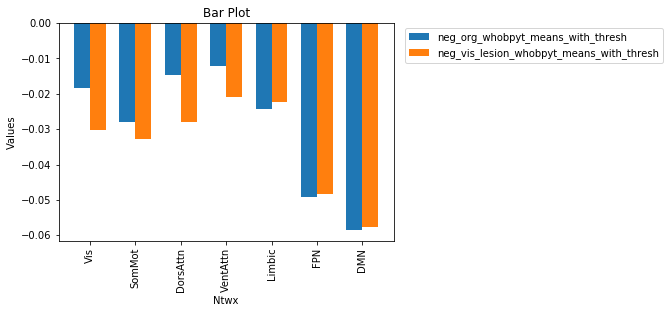

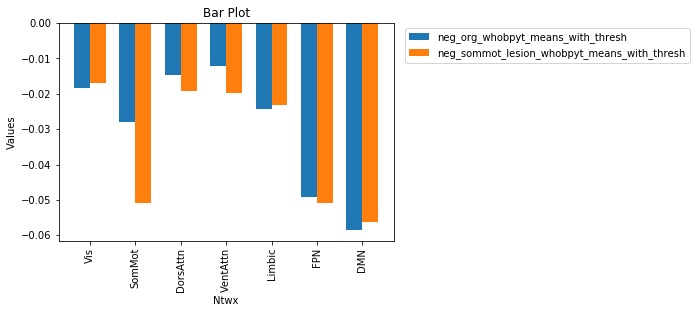

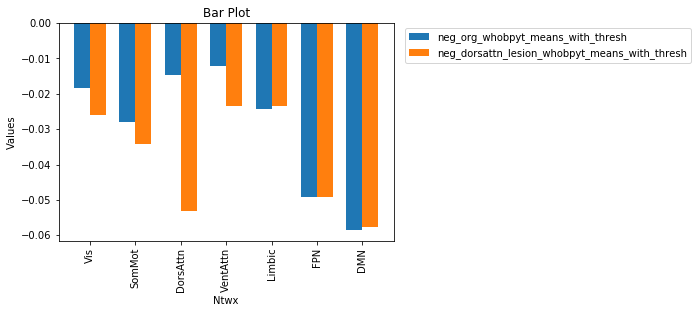

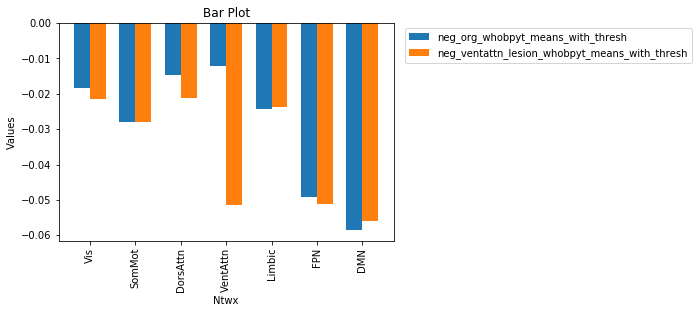

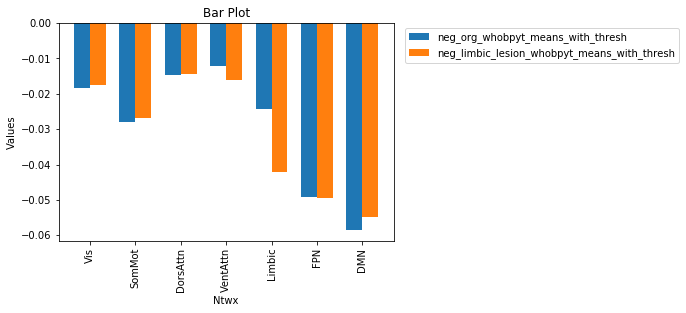

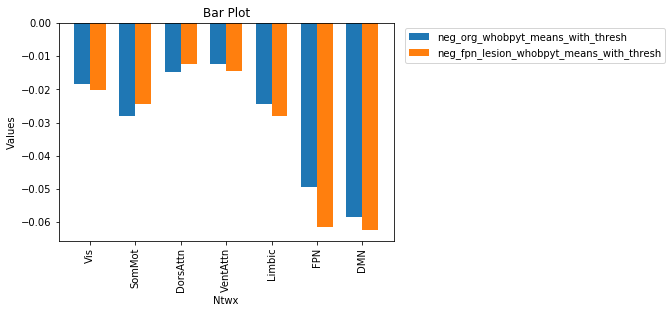

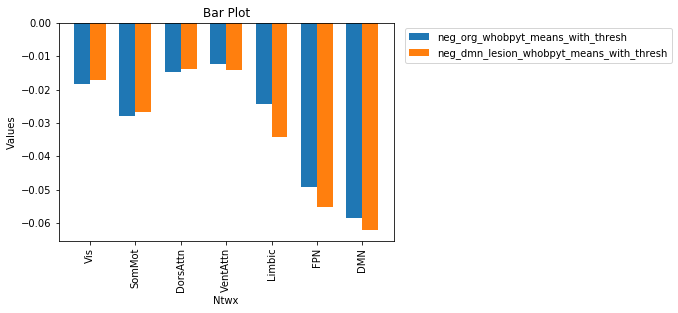

In [462]:
# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_vis_lesion_whobpyt_means_with_thresh, width, label='neg_vis_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_sommot_lesion_whobpyt_means_with_thresh, width, label='neg_sommot_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_dorsattn_lesion_whobpyt_means_with_thresh, width, label='neg_dorsattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Ventattn

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_ventattn_lesion_whobpyt_means_with_thresh, width, label='neg_ventattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Limbic

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_limbic_lesion_whobpyt_means_with_thresh, width, label='neg_limbic_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()



#### FPN

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_fpn_lesion_whobpyt_means_with_thresh, width, label='neg_fpn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### DMN lesion

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_dmn_lesion_whobpyt_means_with_thresh, width, label='neg_dmn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

In [491]:
import scipy

In [493]:
scipy.io.loadmat??

In [ ]:
# Next step: re-introduce sc for each of the other networks 